In [4]:
%matplotlib inline
import os
import mujoco
import numpy as np
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium import spaces
from gymnasium.spaces import Box
from typing import Dict, Union
import matplotlib.pyplot as plt
import matplotlib.animation as animation


DEFAULT_CAMERA_CONFIG = {
    "trackbodyid": -1,
    "distance": 4.0,
}

class MyRobotEnv(MujocoEnv):
    def __init__(
        self, 
        xml_path = "/workspace/ros2_ws/src/airhockey2025/ka/assets/crane_x7.xml",
        frame_skip: int = 5,
        default_camera_config: Dict[str, Union[float, int]] = DEFAULT_CAMERA_CONFIG,
        **kwargs,
    ):
        # 一度モデルを読み込んで観測次元を取得
        model = mujoco.MjModel.from_xml_path(xml_path)
        obs_dim = model.nq + model.nv
        observation_space = Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

        # 行動空間：joint velocities [-1, 1] 正規化
        # 現状はmodelのアクチュエータが認識していないので、model.nuがなくなっている
        # そのため, model.ctrlもないのでstepができない状態
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(model.nu,), dtype=np.float32
        )
        print(self.action_space)
        
        # 親クラスの初期化
        super().__init__(
            model_path=xml_path,
            frame_skip=frame_skip,
            observation_space=observation_space,
            render_mode="rgb_array",
            default_camera_config=default_camera_config,
            **kwargs,
        )
        
        self.metadata = {
            "render_modes": [
                "human",
                "rgb_array",
                "depth_array",
                "rgbd_tuple",
            ],
            "render_fps": int(np.round(1.0 / self.dt)),
        }

    def step(self, action):
        # 正規化されたactionをスケーリング
        scaled_action = action * self.model.actuator_ctrlrange[:, 1]
        self.do_simulation(scaled_action, self.frame_skip)

        obs = self._get_obs()
        reward = self._compute_reward(obs, action)
        done = False
        info = {}

        return obs, reward, done, info

    def _get_obs(self):
        return np.concatenate([self.data.qpos.flat, self.data.qvel.flat])

    def _compute_reward(self, obs, action):
        # エンドエフェクタの位置を使用した報酬例
        # end_effector_pos = self.data.site_xpos[self.model.site_name2id("ee_site")]
        # goal = np.array([0.5, 0.0, 0.2])
        # dist = np.linalg.norm(end_effector_pos - goal)
        # return -dist
        return 0

    def reset_model(self):
        # ランダム初期化
        qpos = self.init_qpos + np.random.uniform(-0.01, 0.01, size=self.model.nq)
        qvel = self.init_qvel + np.random.uniform(-0.01, 0.01, size=self.model.nv)
        self.set_state(qpos, qvel)
        return self._get_obs()

Box(-1.0, 1.0, (9,), float32)


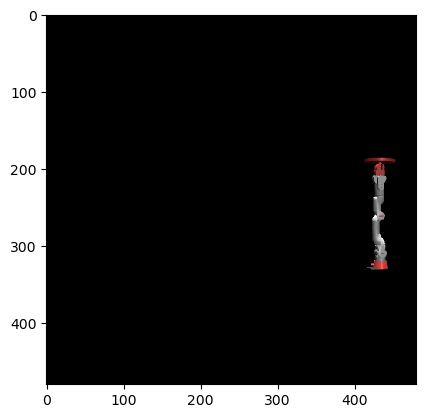

In [7]:
env = MyRobotEnv()
env.reset()
#images = []
fig, ax = plt.subplots() # FigureとAxesを明示的に作成

for i in range(100): # ステップ数を減らして試す
    action = env.action_space.sample()
    env.step(action)
    img = env.render()
    im = ax.imshow(img, animated=True) # Axesに画像を描画し、Artistオブジェクトを取得
    plt.show()

    #images.append([im]) # ArtistAnimationにはArtistオブジェクトのリストのリストを渡す

#ani = animation.ArtistAnimation(fig, images, interval=100, blit=True)

In [ ]:
plt.(images[0][0])